In [ ]:
import numpy as np
import sklearn as sk
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.cluster import KMeans
from sklearn import metrics
import math
from yellowbrick.cluster import SilhouetteVisualizer

In [ ]:
n = 100000

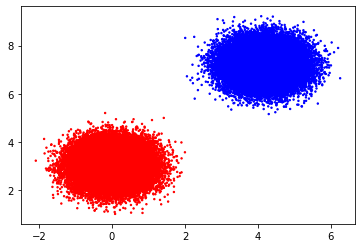

In [3]:
blobs, blob_labels = sk.datasets.make_blobs(n_samples=n, n_features=2, center_box=(0, 10.0), centers=2, cluster_std=0.5, random_state=1)
blobs = blobs.round(3)
plt.scatter(blobs[:, 0], blobs[:, 1], c=blob_labels, cmap="bwr", s=2);

In [ ]:
k = 2
d = 2 #0.00005 #0.000005 #0.0000005
eps = 0.1
X = blobs
n_initial = len(X) # the size of the current point set, a.k.a. n is all of the initial points

In [ ]:
def visualize_splitting(Z, c_centers, lines, X, initial_bbox, title="Sub-Cell Construction"):
    plt.figure(figsize=(8, 6))

    # Plot the initial bounding box
    bbox = np.array(initial_bbox)
    plt.plot(bbox[:, 0], bbox[:, 1], color='green', linestyle='-', linewidth=1) #label='Initial Bounding Box'

    # Plot the original points
    plt.scatter(X[:, 0], X[:, 1], color='blue', marker='.', label='Original Points')

    # Plot cell centers
    centers = np.array(c_centers)
    plt.scatter(centers[:, 0], centers[:, 1], color='red', marker='x', label='Cell Centers', s=45)

    # Plot the splitting lines
    for line in lines:
        for rect_coords in line:
            rect = patches.Rectangle(
                (rect_coords[0][0], rect_coords[1][0]),  # Bottom-left and top-right corner
                rect_coords[0][1] - rect_coords[0][0],   # Width
                rect_coords[1][1] - rect_coords[1][0],   # Height
                edgecolor='green', facecolor='none')
            plt.gca().add_patch(rect)

    plt.title(title)
    plt.axis("off")
    #plt.xlabel('X-axis')
    #plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(False)
    plt.show()

In [ ]:
def recursive_split(X, cell, k, d, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines, Z, c_centers):
    x1, x2, y1, y2 = cell
    points_in_cell = X[(X[:, 0] >= x1) & (X[:, 0] < x2) & (X[:, 1] >= y1) & (X[:, 1] < y2)]
    
    threshold = ((delta)*opt) / pow(2, i)
    print("Threshold value:", round(threshold, 5), "Points in cell:", len(points_in_cell))
    if len(points_in_cell) < threshold:
        # If there are less than the threshold number of points, it's a light cell
        # First time this is checked, it checks the grid g**i if it is light (step #3)
        # Afterwards when it recurs it does step #3.4, marks c as a light cell and adds it to Z
        # Also when it recurs it does step #3.5 here (delete c from Y) as the light cell c will no longer be recured
        
        if len(points_in_cell) >= 1: 
            #print("\033[1m Points in light cell:\n", points_in_cell, "\033[0;0m")
            # If c is not empty (this already checks step #4)
            Z.append(points_in_cell)
            # Save the center coordinates for step #4.1
            c_centers.append(((x1 + x2) / 2, (y1 + y2) / 2))
    else: 
        #print("Current number of cells: " + str(nr_of_cells))
        # Cell counter, each time a cell gets split into 4 subcells the total increases by 3
        nr_of_cells = nr_of_cells + 3

        # The would-be number of cells if the below code executes
        # Does not allow to create more subcells than cs
        if i>=0 and len(points_in_cell)!=0:# and i >= np.log(delta * opt)+1: # and nr_of_cells <= cs:
        
            # Step #3.1 if c is heavy then: Split the cell
            # First time this executes - only if g**i is heavy and splits it into 4 sub-cells c1, c2, c3, c4 (step #3)
            # Afterwards the level of each cell goes to g**i-1, with side length 2**i-1 with each recursion
            i = i - 1
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            
            lines.append([
                ((x1, mid_x), (y1, mid_y)),  # Top-left
                ((mid_x, x2), (y1, mid_y)),  # Top-right
                ((x1, mid_x), (mid_y, y2)),  # Bottom-left
                ((mid_x, x2), (mid_y, y2))])  # Bottom-right
            
            cells = [
                (x1, mid_x, y1, mid_y),  # Top-left
                (mid_x, x2, y1, mid_y),  # Top-right
                (x1, mid_x, mid_y, y2),  # Bottom-left
                (mid_x, x2, mid_y, y2)   # Bottom-right
            ]
            # Step #3.2 and #3.3 as it implicitly adds c1, c2, c3, c4 to Y with each recursion below
            for sub_cell in cells:
                recursive_split(points_in_cell, sub_cell, k, d, eps, opt, n_initial, delta, nr_of_cells, cs, i, lines,
                                Z, c_centers)
    return Z, c_centers, lines

In [ ]:
def coreset(Z, rep_c, delta, cs, eps):
    
    # rep_c = c_centers = representative center point of a cell
    # n_c = number of  points in each cell
    n_c = [len(c) for c in Z]
    
    # S = pairs respective center coordinates with number of points in each cell
    S = []
    for index in range(0, len(rep_c)):
        S.append([rep_c[index], n_c[index]])
    #print(rep_c, n_c)
    if len(S) > cs*(1+eps) or len(S) == 0:
        return None # failure indication
    else:
        return S

In [ ]:
def coreset_construction(X, k, d, eps, n_initial):
    
    if X.size > 0: 
        print("The array is non-empty, proceeding with coreset construction algorithm")
        
        # Step #1: Define the boundaries of the coordinate plane, at the start let Y be the only cell in grid g^(log(D))
        x_min, x_max, y_min, y_max = min(X[:, 0]), max(X[:, 0]), min(X[:, 1]), max(X[:, 1])
        Y = x_min, x_max, y_min, y_max
        
        # Calculate delta
        #delta below 6 fails to construct coreset
        delta = ( 1 / ( (4*k*np.sqrt(d)) * (np.log(n_initial)+1) ) )
        if delta < 1: delta = 6
        #delta = ( 1 / ( (4*k*np.sqrt(d)) * (np.log(n_initial)+1) ) ) * pow( ( eps / (14*np.sqrt(d)) ), d)
        print("delta =", round(delta, 4))
        # Calculate coreset size
        cs = math.ceil(2/delta + (np.log(n_initial) + 2) * k * pow(2, d))
        print("cs =", cs)
        DELTA = 6 # take DELTA as an arbitrary constant, lets say 5
        # Opt = number of guesses for opt approx., round up: (delta+1) * log_base(1 + eps)(DELTA) * (sqrt(2))
        Opt =  math.ceil( (delta+1) * (np.log(np.sqrt(DELTA))/np.log(1 + eps)) * np.sqrt(2) )
        print("Number of guesses for opt approximation =", Opt)

        for j in range(0, Opt):
            print("\nIteration j = " + str(j) + ", with approximation Opt = (1+eps)^j = " + str(pow((1+eps), j)) + "\n")
            
            # Cell counter
            nr_of_cells = 1
            # i-th iteration tracking for recursive alg
            i = DELTA
            # Lines defining sub-cell boundries
            lines = []
            # Step #0: arr to store light cells c
            Z = []
            # Cell centers
            c_centers = []

            # Start the recursive splitting, here Opt = (1+eps)^j
            Z, c_centers, lines = recursive_split(X, Y, k, d, eps, pow((1+eps), j), n_initial,
                                                  delta, nr_of_cells, cs, i, lines, Z, c_centers)
            # Start the coreset calculation
            S = coreset(Z, c_centers, delta, cs, eps)
                        
            if S is not None:
                print("\n Coreset constructed: \n", S, ", of size:", len(S))
                
                initial_bbox = [[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max], [x_min, y_min]]
                visualize_splitting(Z, c_centers, lines, X, initial_bbox)
                
                return S
        return "Coreset could not be constructed"
    else:
        return "The array is empty."

In [ ]:
S = coreset_construction(X, k, d, eps, n_initial)

# K means for blobs

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=0)
y_kmeans = kmeans.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=2, cmap='bwr')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='orange', s=200, alpha=0.8, marker='X')
plt.title('K-Means Clustering')
plt.show()

In [ ]:
silhouette_score = metrics.silhouette_score(X, y_kmeans)
inertia = kmeans.inertia_

print(f"Silhouette Score: {silhouette_score}") #how well-separated the clusters are
print(f"Inertia: {inertia}") # how far the points within a cluster are from the center of that cluster.

# K means for coreset of blobs

In [ ]:
coordinates = np.array([item[0] for item in S])
coreset_array = coordinates.reshape(-1, 2)
coreset_array[0:5]

In [ ]:
corekmeans = KMeans(n_clusters=2, random_state=0)
y_corekmeans = corekmeans.fit_predict(coreset_array, sample_weight= [item[1] for item in S])

plt.scatter(coreset_array[:, 0], coreset_array[:, 1], c=y_corekmeans, s=2, cmap='bwr')
corecenters = corekmeans.cluster_centers_
plt.scatter(corecenters[:, 0], corecenters[:, 1], c='orange', s=200, alpha=0.8, marker='X')
plt.title('K-Means Coreset Clustering')
plt.show()

In [ ]:
silhouette_score_core = metrics.silhouette_score(coreset_array, y_corekmeans)
inertia_core = corekmeans.inertia_

print(f"Silhouette Score: {silhouette_score_core}")
print(f"Inertia: {inertia_core}")

# Half circles (moons)

In [ ]:
moons, moon_labels = sk.datasets.make_moons(n_samples=n, random_state=1, noise = 0.08)
moons = moons.round(3)
plt.scatter(moons[:, 0], moons[:, 1], c=moon_labels, cmap="bwr", s=5);

In [ ]:
S_moons = coreset_construction(moons, k, d, eps, len(moons)); 

# K means for moons

In [ ]:
kmeans_moons = KMeans(n_clusters=2, random_state=0)
y_kmeans_moons = kmeans_moons.fit_predict(moons)

plt.scatter(moons[:, 0], moons[:, 1], c=y_kmeans_moons, s=2, cmap='bwr')
centers_moons = kmeans_moons.cluster_centers_
plt.scatter(centers_moons[:, 0], centers_moons[:, 1], c='orange', s=200, alpha=0.8, marker='X')
plt.title('K-Means Clustering')
plt.show()

In [ ]:
silhouette_score_moons = metrics.silhouette_score(moons, y_kmeans_moons)
inertia_moons = kmeans_moons.inertia_

print(f"Silhouette Score: {silhouette_score_moons}") #how well-separated the clusters are
print(f"Inertia: {inertia_moons}") # how far the points within a cluster are from the center of that cluster.

# K means for coreset of moons

In [ ]:
coordinates_moons = np.array([item[0] for item in S_moons])
coreset_array_moons = coordinates_moons.reshape(-1, 2)
coreset_array_moons[0:5]

In [ ]:
corekmeans_moons = KMeans(n_clusters=2, random_state=0)
y_corekmeans_moons = corekmeans_moons.fit_predict(coreset_array_moons, sample_weight= [item[1] for item in S_moons])

plt.scatter(coreset_array_moons[:, 0], coreset_array_moons[:, 1], c=y_corekmeans_moons, s=2, cmap='bwr')
corecenters_moons = corekmeans_moons.cluster_centers_
plt.scatter(corecenters_moons[:, 0], corecenters_moons[:, 1], c='orange', s=200, alpha=0.8, marker='X')
plt.title('K-Means Coreset Clustering')
plt.show()

In [ ]:
silhouette_score_core_moons = metrics.silhouette_score(coreset_array_moons, y_corekmeans_moons)
inertia_core_moons = corekmeans_moons.inertia_

print(f"Silhouette Score: {silhouette_score_core_moons}") #how well-separated the clusters are
print(f"Inertia: {inertia_core_moons}") # how far the points within a cluster are from the center of that cluster.

# Circles

In [ ]:
circles, circles_labels = sk.datasets.make_circles(n_samples=n, random_state=1, noise = 0.07, factor=0.4)
circles = circles.round(3)
plt.scatter(circles[:, 0], circles[:, 1], c=circles_labels, cmap="bwr", s=8);

In [ ]:
S_circles = coreset_construction(circles, k, d, eps, len(circles));

# K means for circles

In [ ]:
kmeans_circles = KMeans(n_clusters=2, random_state=0)
y_kmeans_circles = kmeans_circles.fit_predict(circles)

plt.scatter(circles[:, 0], circles[:, 1], c=y_kmeans_circles, s=2, cmap='bwr')
centers_circles = kmeans_circles.cluster_centers_
plt.scatter(centers_circles[:, 0], centers_circles[:, 1], c='orange', s=200, alpha=0.8, marker='X')
plt.title('K-Means Clustering')
plt.show()

In [ ]:
silhouette_score_circles = metrics.silhouette_score(circles, y_kmeans_circles)
inertia_circles = kmeans_circles.inertia_

print(f"Silhouette Score: {silhouette_score_circles}") #how well-separated the clusters are
print(f"Inertia: {inertia_circles}") # how far the points within a cluster are from the center of that cluster.

# K means for coreset of circles

In [ ]:
coordinates_circles = np.array([item[0] for item in S_circles])
coreset_array_circles = coordinates_circles.reshape(-1, 2)
coreset_array_circles[0:5]

In [ ]:
corekmeans_circles = KMeans(n_clusters=2, random_state=0)
y_corekmeans_circles = corekmeans_circles.fit_predict(coreset_array_circles, sample_weight= [item[1] for item in S_circles])

plt.scatter(coreset_array_circles[:, 0], coreset_array_circles[:, 1], c=y_corekmeans_circles, s=2, cmap='bwr')
corecenters_circles = corekmeans_circles.cluster_centers_
plt.scatter(corecenters_circles[:, 0], corecenters_circles[:, 1], c='orange', s=200, alpha=0.8, marker='X')
plt.title('K-Means Coreset Clustering')
plt.show()

In [ ]:
silhouette_score_circles = metrics.silhouette_score(coreset_array_circles, y_corekmeans_circles)
inertia_circles = corekmeans_circles.inertia_

print(f"Silhouette Score: {silhouette_score_circles}") #how well-separated the clusters are
print(f"Inertia: {inertia_circles}") # how far the points within a cluster are from the center of that cluster.

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

#blobs
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axs[0],
                                  title=f"Silhouette plot, KMeans for {X.shape[0]} samples, k = {k}")
visualizer.fit(X)
visualizer.finalize()

#blobs core
visualizer = SilhouetteVisualizer(corekmeans, colors='yellowbrick', ax=axs[3],
                                  title=f"Silhouette plot, KMeans for {coreset_array.shape[0]} samples, k = {k}")
visualizer.fit(coreset_array)
visualizer.finalize()

#moons
visualizer = SilhouetteVisualizer(kmeans_moons, colors='yellowbrick', ax=axs[1],
                                  title=f"Silhouette plot, KMeans for {moons.shape[0]} samples, k = {k}")
visualizer.fit(moons)
visualizer.finalize()

#moons core
visualizer = SilhouetteVisualizer(corekmeans_moons, colors='yellowbrick', ax=axs[4],
                                  title=f"Silhouette plot, KMeans for {coreset_array_moons.shape[0]} samples, k = {k}")
visualizer.fit(coreset_array_moons)
visualizer.finalize()

#circles
visualizer = SilhouetteVisualizer(kmeans_moons, colors='yellowbrick', ax=axs[2],
                                  title=f"Silhouette plot, KMeans for {circles.shape[0]} samples, k = {k}")
visualizer.fit(circles)
visualizer.finalize()

#circles core
visualizer = SilhouetteVisualizer(corekmeans_circles, colors='yellowbrick', ax=axs[5],
                                  title=f"Silhouette plot, KMeans for {coreset_array_circles.shape[0]} samples, k = {k}")
visualizer.fit(coreset_array_circles)
visualizer.finalize()

fig.suptitle(f'n = {n}', fontsize=16)
plt.tight_layout()
plt.show()